In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
import statsmodels.api as sm

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
df.head()

,index,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,...,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male,target
0,0,9,-1.0,36457,9.0,4.3,0,3,4,2006,...,1,2,13,40.0,2018.0,16,3,0,1,2360
1,2,3,-1.0,44872,8.0,-1.0,3,7,4,1982,...,4,2,13,108.0,1993.0,34,3,0,1,3060
2,4,3,-1.0,55927,16.0,4.2,0,4,5,2014,...,4,2,13,55.0,2019.0,35,3,0,1,2648
3,5,0,-1.0,41405,10.3,-1.0,0,4,4,2000,...,4,2,13,55.0,2003.0,10,3,0,1,2513
4,7,8,-1.0,22523,19.0,-1.0,0,4,8,2000,...,4,1,13,62.0,2005.0,10,3,0,1,2703


## Baseline

In [3]:
X = df.drop(["target"], axis=1)
y = df[["target"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression().fit(train_X, train_y)

print(f'R^2_train = {reg.score(train_X, train_y)}')
print(f'R^2_test = {reg.score(test_X, test_y)}')
print(f'MSE_train = {mean_squared_error(reg.predict(train_X), train_y)}')
print(f'MSE_test = {mean_squared_error(reg.predict(test_X), test_y)}')

R^2_train = 0.45554067850400504
R^2_test = 0.4646243987792361
MSE_train = 29840.12125086529
MSE_test = 31021.024399854425


## Задача
- Данные: технические характеристики разных конфигураций автомобилей
- Таргет: длина колесной базы конфигурации (в миллиметрах).
- Задача: добиться наименьшего MSE на test.

До того как проводить корреляционный анализ для выявления зависимостей между таргетом и признаками стоит на базовом уровне понять с какими факторами мы имеем дело и как каждый из них в теории может влиять на длину колесной базы конфигурации 

In [6]:
#df.info() #здесь убедились, что пропусков таблица не имеет, проблем с типом данных также не обнаружено, что уже хорошо
# df.duplicated().sum() = 0 дубликаов тоже нет

In [7]:
df.rename(columns=lambda x: x.replace('-', '_'), inplace=True) #сначала для удобства заменим "-" на "_"

In [8]:
df.columns

Index(['index', 'back_suspension', 'battery_capacity', 'charge_time',
       'compression', 'consumption_mixed', 'cylinders_order',
       'cylinders_value', 'engine_feeding', 'engine_start', 'engine_stop',
       'engine_type', 'gear_type', 'luxury', 'max_speed', 'power_electro_kw',
       'supply_system', 'valves', 'valvetrain', 'weight',
       'configurations_auto_premiere', 'configurations_back_wheel_base',
       'configurations_front_brake', 'configurations_safety_rating',
       'configurations_seats', 'configurations_tank_volume',
       'supergen_year_stop', 'models_country_from', 'models_group',
       'models_light_and_commercial', 'models_male', 'target'],
      dtype='object')

In [9]:
for i in df.columns:
    print(f'{i} column :{df[i].unique()}')
    
# Так как нет описания предоставленных данных было бы неплохо посмотреть на разброс значений по столбцам, 
# чтобы понять что может представлять собой та или иная колонка (по названию эо сделать нельзя)

index column :[    0     2     4 ... 61226 61227 61228]
back_suspension column :[ 9  3  0  8 10  6  7  1  4  5  2]
battery_capacity column :[ -1.    13.2   21.     1.56  41.    10.7    1.3   23.     6.5   90.
  18.4  100.    14.1    9.2  130.    24.    75.    13.5    1.4   17.6
  12.    21.3   31.3   58.    78.    60.    22.    18.8   40.     4.4
  30.    45.     8.7  120.    62.    50.    10.4    1.1   27.2  200.
  33.     6.8   93.4    1.31  64.    32.6    9.27  11.6    7.6    5.5
  14.4   16.    79.2   41.4   31.2   28.     1.5   13.    77.    17.1
   7.9   42.2   47.17  95.    37.    16.5   25.5   17.    11.2   10.8
  10.5   70.    39.2    7.7   71.  ]
charge_time column :[36457 44872 55927 ...  8958 20293 52459]
compression column :[ 9.    8.   16.   10.3  19.    9.6  16.5  -1.   21.    8.5   9.3   9.8
 18.   10.    9.9  11.   17.    9.5  10.4   8.8  10.2  10.5  10.8   9.2
 22.    9.7  17.9  10.7  10.1  18.3  11.2   8.2   8.75 11.3  23.   10.25
  7.3  11.1  18.4  18.1   8.3   8.6 

### Описание данных и работа над их качеством 
1.  **'back-suspension'** - задняя подвеска. 

Значения от 1 до 10 скорее всего, относятся к оценке ее характеристик, таких как жесткость, управляемость, комфорт или другие параметры, где 1 - низкий, а 10 - самый высокий уровень

2. **'battery_capacity'** - емкость аккумулятора.

3. **'charge_time'** - время необходимое для зарядки аккумулятора 

df['charge_time'].describe() --> есть выбросы по нижней границе и величина значений говорит о том,что они представлены в секундах, т.к. большинство значений между 45820.2 и 61174, а среднее время заряда аккумулятора - 10-12 часов

 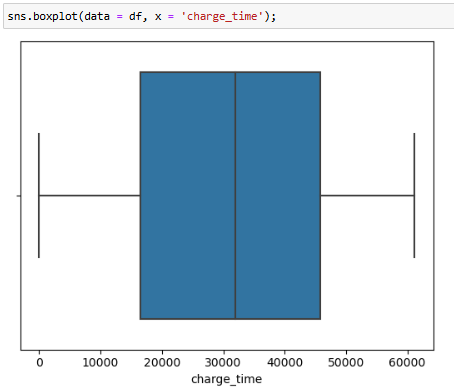 
<u>Примечание 1</u>: удалим выбросы по нижней границе

4. **'compression'** - степени сжатия двигателя внутреннего сгорания. 
Чем выше степень сжатия, тем выше КПД двигателя. Низкие значения (6-9), средние (9-12) — типичные для атмосферных бензиновых двигателей, высокие (13-23) — характерны для высокопроизводительных бензиновых двигателей 

5. **'consumption_mixed'** - смешанный расход топлива, обычно измеряемый в литрах на 100 км.
<u>Примечание 2</u>: Значение "-1" может означать отсутствие данных или ошибку в записи (можем их убрать) 

6. **'cylinders_order'** - "порядок цилиндров в двигателе", но не похоже на порядок, тк данные представлены не списками или строками, а целыми числами, причем их немного, так что  скорее всего, это категориальные данные,например, номер группы цилиндров

7. **'cylinders_value'** - реальное количество цилиндров в двигателе
Обычно встречаются двигатели с 3, 4, 5, 6, 8, 10 цилиндрами, а значение 0 может означать электромобиль (без цилиндров).  1 встречается в автомобилях крайне редко 

8. **'engine_feeding'** - данные похожи на категориальные, это вероятно, категория системы подачи топлива 
9. **'engine_start'** - год начала производства двигателя или модели автомобиля
10. **'engine_stop'** -  год окончания производства двигателя или модели автомобиля.  <u>Примечание 3</u> : Значение 0 может означать, что производство все еще продолжается.  
11. **'engine_type'** - похоже на категориальные данные - тип двигателя 
12. **'gear_type'** - похоже на категориальные данные - тип коробки передач
13. **'luxury'** ???
14. **'max_speed'** - максимальная скорость <u>Примечание 4</u>: Значение "-1" может означать отсутствие данных или ошибку в записи (можем их убрать) 
15. **'power_electro_kw'** - мощность электромотора <u>Примечание 5</u>:Значение -1 может означать отсутствие электромотора (обычный ДВС)
16. **'supply_system'** - похоже на категориальные данные - тип системы подачи топлива
17. **'valves'** - количество клапанов.

В норме количество клапанов на двигатель составляет до 8, но тут есть странно большие значения, что может указывать на ошибку в данных. Если проверить через df['valves'].describe(), то правда странно, что третий квартиль равен "2", а максимальное значение "4134"
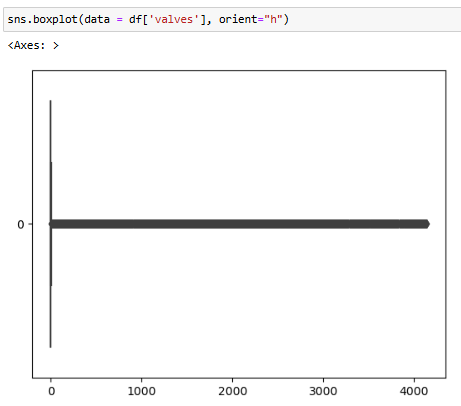. <u>Примечание 6</u> Уберем все значения выше, чем 8

18. **'valvetrain'** -похоже на категориальные данные - клапанный механизм
19. **'weight'** - вес авто <u>Примечание 7</u> Значение "-1" может означать отсутствие данных или ошибку в записи (можем их убрать) 
20. **'configurations_auto_premiere'** - Значения выглядят как уникальные идентификаторы или внутренние коды комплектаций автомобилей.  
21. **'configurations_back_wheel_base'** - Похоже на величину колесной базы задней оси в миллиметрах.  <u>Примечание 8</u>: Значение "-1" может означать отсутствие данных или неизвестное значение.

22. **'configurations_front_brake'** - похоже на категориальные данные -тип передних тормозов
23. **'configurations_safety_rating'** - похоже на категориальные данные - оценка безопасности автомобиля (от 0 до 2).  
24. **'configurations_seats'** - Количество мест в автомобиле (от 2 до 35).
25. **'configurations_tank_volume'** - Объем топливного бака в литрах. <u>Примечание 9</u>: Значение "-1" может означать электромобиль без бака.  
26. **'supergen_year_stop'** -  возможно, год прекращения выпуска модели или поколения автомобиля. <u>Примечание 10</u>: Значение "-1" может означать, что производство все еще продолжается 
27. **'models_country_from'**- вероятно, код страны происхождения модели автомобиля.  
28. **'models_group'** - категория или сегмент модели автомобиля
29. **'models_light_and_commercial'** - бинарная характеристика - легковой автомобиль или коммерческий транспорт.  
30. **'models_male'** - по названию это может быть рейтинг популярности модели среди мужчин, выбор ее в опросах (большой разброс значений)
31. **'target'** - целевая переменная 

In [10]:
Q1 = df['charge_time'].quantile(0.25)
Q3 = df['charge_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
df = df[df['charge_time'] >= lower_bound] # см.примечание 1 выше
df = df.loc[df['consumption_mixed'] > 0] # см.примечание 2 выше
df = df.loc[df['max_speed'] > 0] # см.примечание 4 выше
df = df.loc[df['valves'] <= 8] # см.примечание 6 выше
df = df.loc[df['weight'] > 0]# см.примечание 7 выше
df = df.loc[df['configurations_back_wheel_base'] > 0]# см.примечание 8 выше
df.shape

(20419, 32)

In [11]:
X = df.drop(["target"], axis=1)
y = df[["target"]]

# МОДЕЛЬ

In [12]:
X = df.drop(["target",'index'], axis=1)
y = df[["target"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression().fit(train_X, train_y)

print(f'R^2_train = {reg.score(train_X, train_y)}')
print(f'R^2_test = {reg.score(test_X, test_y)}')
print(f'MSE_train = {mean_squared_error(reg.predict(train_X), train_y)}')
print(f'MSE_test = {mean_squared_error(reg.predict(test_X), test_y)}')

R^2_train = 0.7008841703579186
R^2_test = 0.716922369967697
MSE_train = 10777.753966215096
MSE_test = 10206.602277976192


In [13]:
model = Ridge()
model.fit(train_X,train_y)

#print(model.coef_, model.intercept_)
predictions = model.predict(test_X)

print(f'R^2_train = {reg.score(train_X, train_y)}')
print(f'R^2_test = {reg.score(test_X, test_y)}')
print(f'MSE_train = {mean_squared_error(reg.predict(train_X), train_y)}')
print(f'MSE_test = {mean_squared_error(reg.predict(test_X), test_y)}')

R^2_train = 0.7008841703579186
R^2_test = 0.716922369967697
MSE_train = 10777.753966215096
MSE_test = 10206.602277976192


C:\Users\Honor\AppData\Local\Temp\ipykernel_23848\2222168541.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)
C:\Users\Honor\AppData\Local\Temp\ipykernel_23848\2222168541.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()],  "k--", color='r')


Text(0.5, 1.0, 'Предсказанные значения vs. Фактические значения')

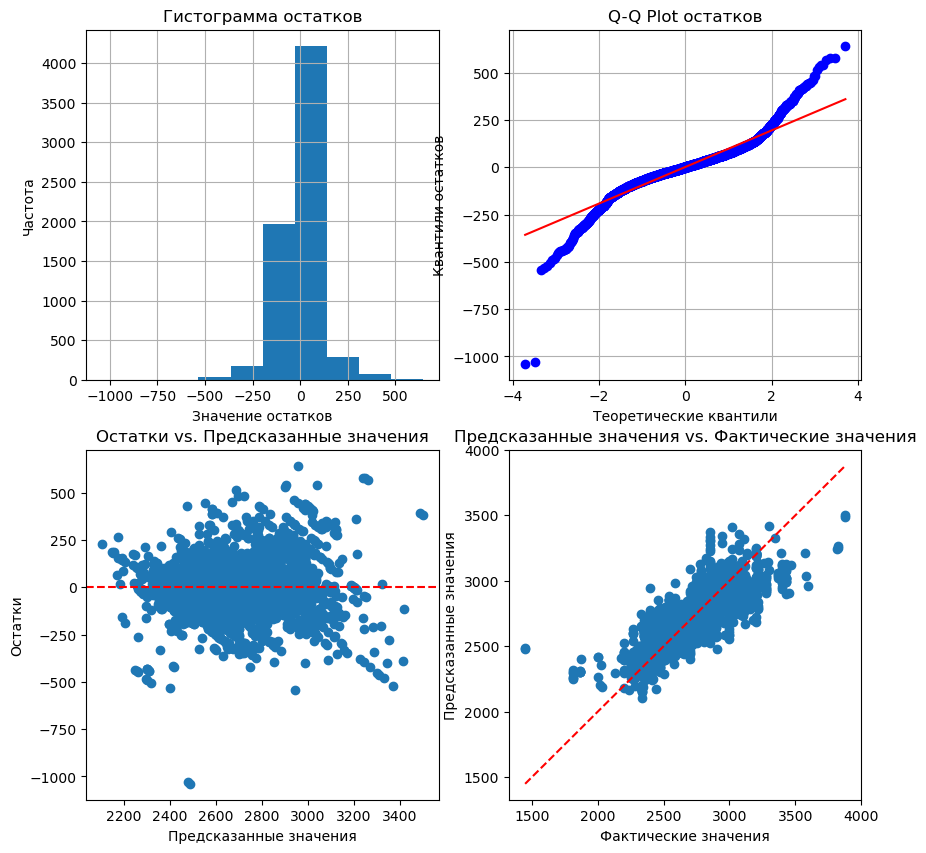

In [14]:
# Получение остатков модели
residuals = test_y - predictions
residuals = np.ravel(np.array(residuals)) # одномерный массив с остатками модели 
# Расчет стандартизированных остатков
stand_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
plt.subplots(figsize=(10, 10))


# Распределение остатков
plt.subplot(2, 2, 1)
plt.hist(residuals)
plt.xlabel('Значение остатков')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid(True)


# График остатков vs. предсказанных значений
plt.subplot(2, 2, 2)
st.probplot(residuals, dist='norm', plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Квантили остатков')
plt.title('Q-Q Plot остатков')
plt.grid(True)

#График остатков относительно прогноза
plt.subplot(2, 2, 3)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs. Предсказанные значения')

# Предсказанные и фактические значения
plt.subplot(2, 2, 4)
plt.scatter(test_y, predictions)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()],  "k--", color='r')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения vs. Фактические значения')